# Object Detection with Faster R-CNN using PyTorch

This tutorial demonstrates how to perform object detection using a pre-trained Faster R-CNN model with ResNet-50 FPN backbone in PyTorch.

## Prerequisites

- Basic knowledge of PyTorch and Computer Vision.
- Installed packages:
  - `torch`
  - `torchvision`
  - `matplotlib`

You can install the required packages using:
```bash
pip install torch torchvision matplotlib


---

## 1. Importing Required Libraries



In [1]:
import os
import time
import torch
import random
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


---

## 2. Loading the Pre-trained Faster R-CNN Model

We use a pre-trained Faster R-CNN model with a ResNet-50 FPN backbone, loaded with COCO dataset weights.



In [ ]:
# Load the pre-trained Faster R-CNN model
weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
model = fasterrcnn_resnet50_fpn(weights=weights)
model.eval()


---

## 3. Image Preprocessing

Prepare the input image by converting it to a tensor, which is the expected input format for PyTorch models.

> **Note:** Replace `'image_path'` with the path to your input image.

In [3]:
# Define image preprocessing
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the test image
image_path = 'PennFudanPed/PNGImages/FudanPed00019.png'  # Local image path
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0)

In [4]:
# Perform inference
with torch.no_grad():
    predictions = model(image_tensor)

# Print model architecture
print("Faster R-CNN Model Architecture:")
print(model)

Faster R-CNN Model Architecture:
FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256,

## 4. Performing Inference

Run inference using the pre-trained model.

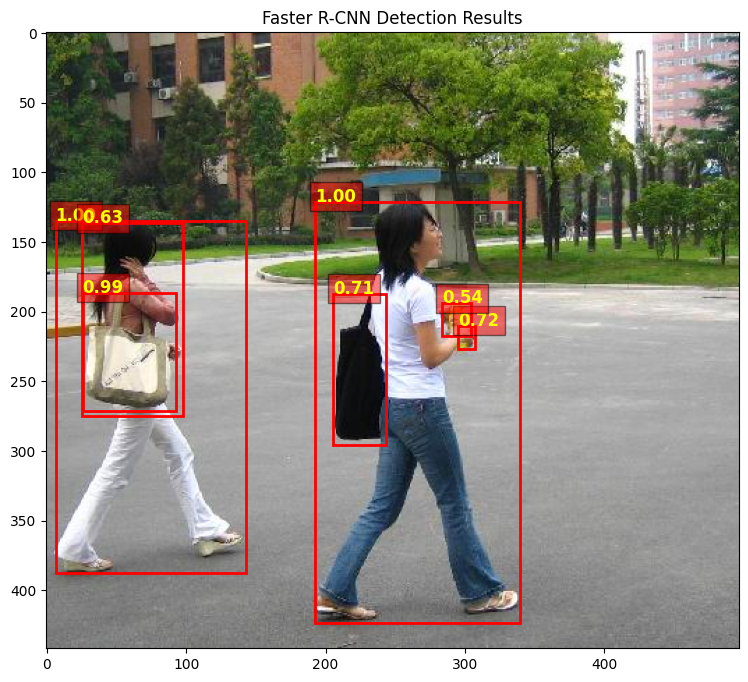

In [5]:
# Visualize detection results
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

# Get predicted boxes and scores
boxes = predictions[0]['boxes']
scores = predictions[0]['scores']
threshold = 0.5  # Confidence threshold

# Draw detection boxes
for box, score in zip(boxes, scores):
    if score > threshold:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        ax.text(x1, y1, f'{score:.2f}', color='yellow', fontsize=12, weight='bold', 
                bbox=dict(facecolor='red', alpha=0.5))

plt.title("Faster R-CNN Detection Results")
plt.show()

In [6]:
image_dir = 'PennFudanPed/PNGImages/'
all_images = os.listdir(image_dir)
selected_images = random.sample(all_images, 8)

In [7]:
images = []  
tensors = [] 
predictions = [] 

for img_name in selected_images:
    img_path = os.path.join(image_dir, img_name)
    image = Image.open(img_path).convert("RGB")
    images.append(image)
    image_tensor = transform(image).unsqueeze(0)
    tensors.append(image_tensor)

with torch.no_grad():
    for image_tensor in tensors:
        prediction = model(image_tensor)
        predictions.append(prediction)

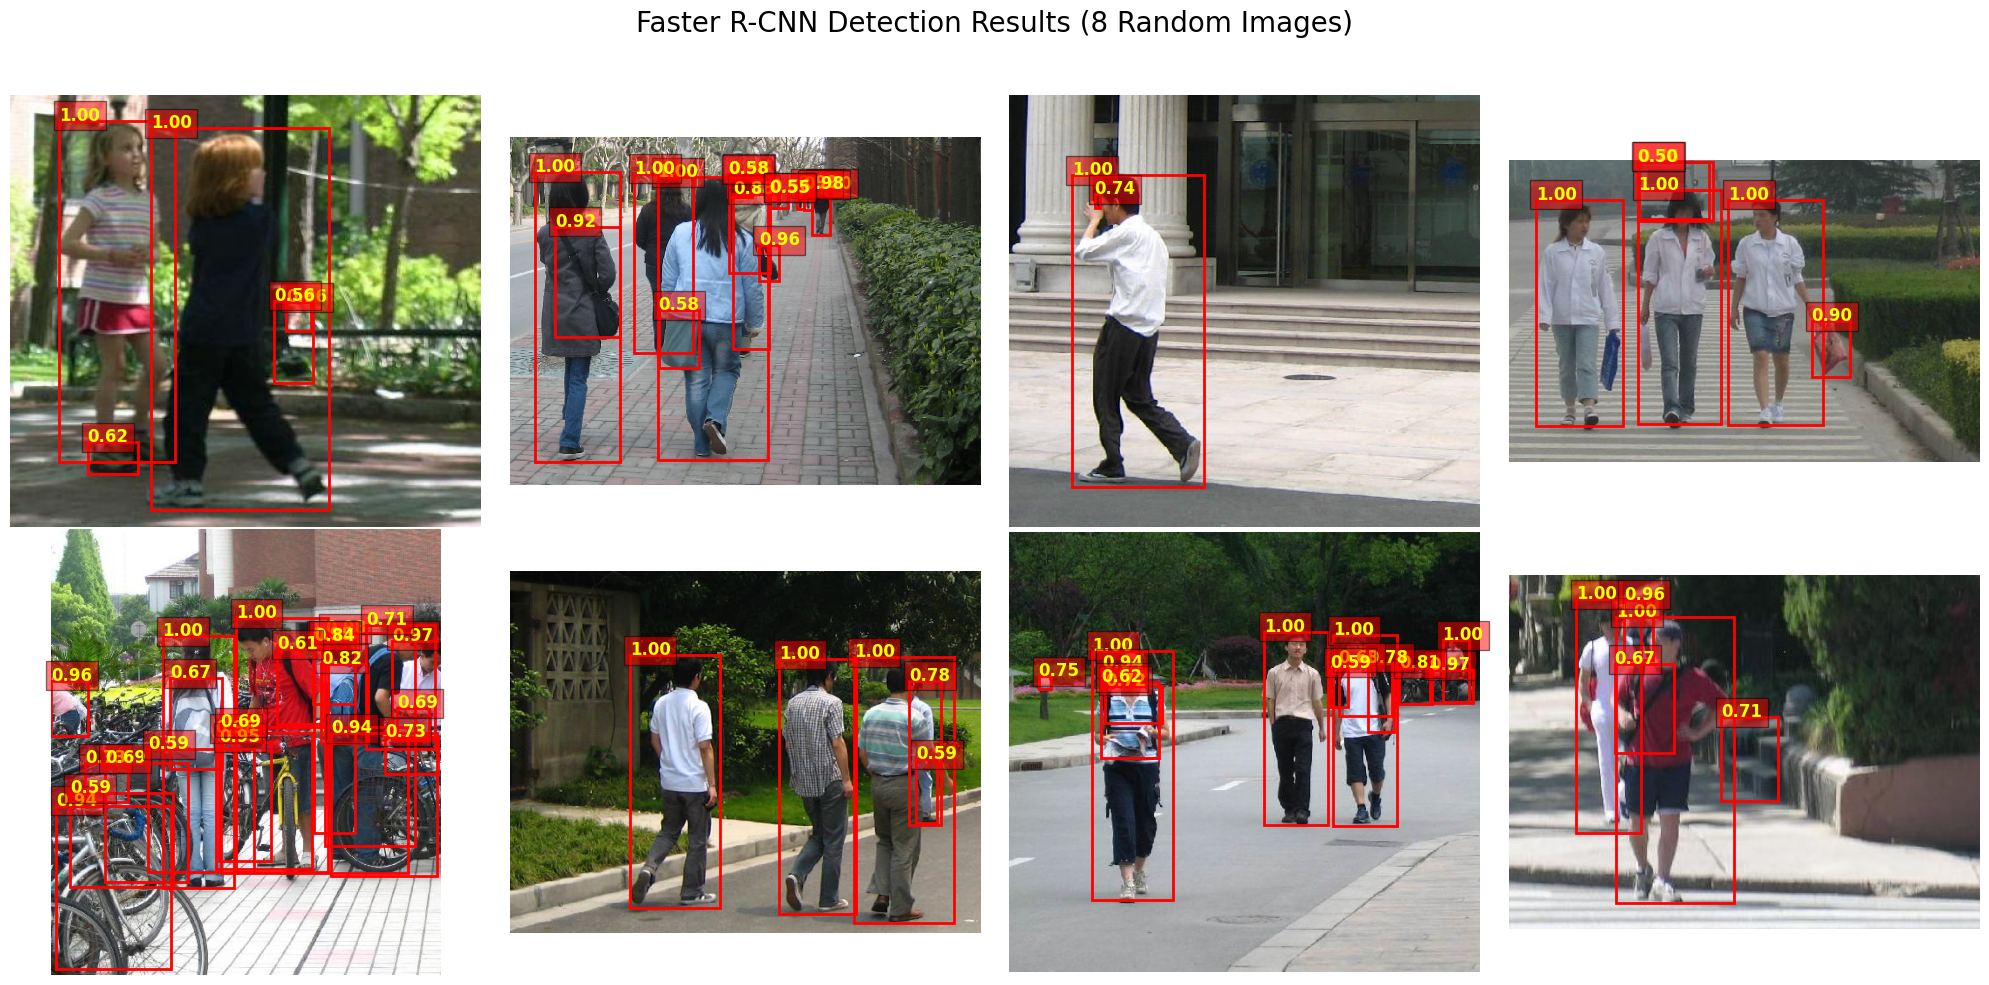

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

for i, (image, prediction) in enumerate(zip(images, predictions)):
    axs[i].imshow(image)

    boxes = prediction[0]['boxes']
    scores = prediction[0]['scores']
    labels = prediction[0]['labels']
    threshold = 0.5  # Confidence threshold

    for box, score in zip(boxes, scores):
        if score > threshold:
            x1, y1, x2, y2 = box.tolist()
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                                     linewidth=2, edgecolor='red', facecolor='none')
            axs[i].add_patch(rect)

            axs[i].text(x1, y1, f'{score:.2f}', color='yellow', fontsize=12, weight='bold', 
                        bbox=dict(facecolor='red', alpha=0.5))

    axs[i].axis('off')

plt.suptitle("Faster R-CNN Detection Results (8 Random Images)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [9]:
def calculate_fps(model, tensors):
    start_time = time.time()
    
    with torch.no_grad():
        for image_tensor in tensors:
            _ = model(image_tensor)
    
    end_time = time.time()
    total_time = end_time - start_time
    fps = len(tensors) / total_time
    
    print(f'Average FPS: {fps:.2f}')

calculate_fps(model, tensors)

Average FPS: 0.31


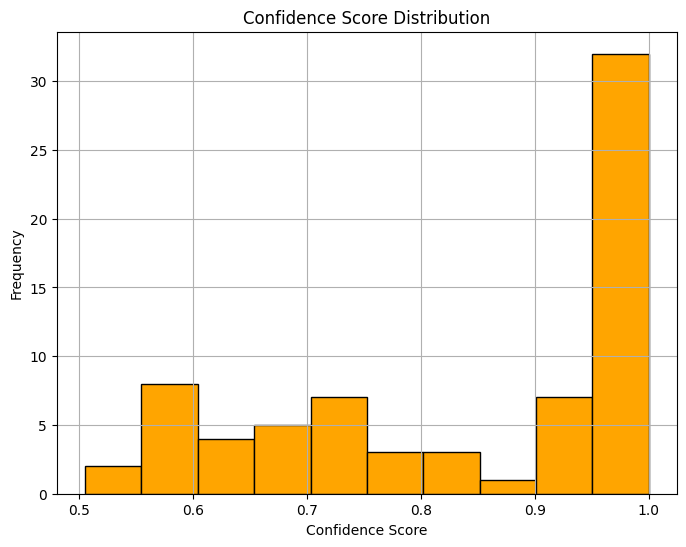

In [10]:
def plot_confidence_distribution(predictions, threshold=0.5):
    scores_list = []

    for prediction in predictions:
        scores = prediction[0]['scores'].cpu().numpy()

        for score in scores:
            if score > threshold:
                scores_list.append(score)

    plt.figure(figsize=(8, 6))
    plt.hist(scores_list, bins=10, color='orange', edgecolor='black')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Confidence Score Distribution')
    plt.grid(True)
    plt.show()

plot_confidence_distribution(predictions)


---

## 5. Summary

This tutorial demonstrates how to:
- Load a pre-trained Faster R-CNN model with ResNet-50 FPN backbone.
- Perform image preprocessing for object detection.
- Run inference to get detection results.
- Visualize detection results using bounding boxes and labels.
